In [1]:
# gpu check
! nvidia-smi

Mon Oct 16 13:28:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:3A:00.0 Off |                    0 |
| N/A   32C    P0    41W / 300W |      9MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   

In [3]:
cd /pfs/data5/home/hd/hd_hd/hd_nf283/MA_Thesis/

/pfs/data5/home/hd/hd_hd/hd_nf283/MA_Thesis


In [4]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda
# from tensorflow.keras.models import Model
from tensorflow.keras import models
import pickle
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping
import pandas as pd
import json
from torch.utils.data import Dataset
from transformers import AutoTokenizer, pipeline, AutoModel
import resources.smart_cond as sc
# from google.colab import files

2023-10-16 13:28:20.996697: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-16 13:28:21.043423: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 13:28:22.398286: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
data_path = 'Data/sepsis_removed_0.pkl'
pkl = pickle.load(open(data_path, 'rb'))
data = pkl[0]
oc = pkl[1]
train_ind = pkl[2]
valid_ind = pkl[3]
test_ind = pkl[4]
del pkl

In [6]:
data.loc[data['variable'] == 'Text', 'value'] = 1

In [7]:
pred_window = 2 # hours
obs_windows = range(20, 124, 4)

# Remove train, val patients
data = data.merge(oc[['ts_ind', 'SUBJECT_ID']], on='ts_ind', how='left')
train_sub = oc.loc[oc.ts_ind.isin(train_ind)].SUBJECT_ID.unique()
valid_sub = oc.loc[oc.ts_ind.isin(valid_ind)].SUBJECT_ID.unique()
data = data.loc[~data.SUBJECT_ID.isin(train_sub)]
data = data.loc[~data.SUBJECT_ID.isin(valid_sub)]
oc = oc.loc[~oc.SUBJECT_ID.isin(train_sub)]
oc = oc.loc[~oc.SUBJECT_ID.isin(valid_sub)]

data.drop(columns=['SUBJECT_ID', 'TABLE'], inplace=True)
# Fix age.
data.loc[(data.variable=='Age')&(data.value>200), 'value'] = 91.4
# Get static data with mean fill and missingness indicator.
static_varis = ['Age', 'Gender']
ii = data.variable.isin(static_varis)
static_data = data.loc[ii]
data = data.loc[~ii]
def inv_list(l, start=0):
    d = {}
    for i in range(len(l)):
        d[l[i]] = i+start
    return d
static_var_to_ind = inv_list(static_varis)
D = len(static_varis)
N = data.ts_ind.max()+1
demo = np.zeros((N, D))
for row in tqdm(static_data.itertuples()):
    demo[row.ts_ind, static_var_to_ind[row.variable]] = row.value
# Normalize static data.
means = demo.mean(axis=0, keepdims=True)
stds = demo.std(axis=0, keepdims=True)
stds = (stds==0)*1 + (stds!=0)*stds
demo = (demo-means)/stds

# Get variable indices.
varis = sorted(list(set(data.variable)))
V = len(varis)
var_to_ind = inv_list(varis, start=1)
data['vind'] = data.variable.map(var_to_ind)
data = data[['ts_ind', 'vind', 'hour', 'value']].sort_values(by=['ts_ind', 'vind', 'hour'])
# Find max_len.
fore_max_len = 880
# Get forecast inputs and outputs.
fore_times_ip = []
fore_values_ip = []
fore_varis_ip = []
fore_op = []
fore_inds = []
def f(x):
    mask = [0 for i in range(V)]
    values = [0 for i in range(V)]
    for vv in x:
        v = int(vv[0])-1
        mask[v] = 1
        values[v] = vv[1]
    return values+mask
def pad(x):
    return x+[0]*(fore_max_len-len(x))

22938it [00:00, 594179.47it/s]


In [8]:
for w in tqdm(obs_windows):
    pred_data = data.loc[(data.hour>=w)&(data.hour<=w+pred_window)]
    pred_data = pred_data.groupby(['ts_ind', 'vind']).agg({'value':'first'}).reset_index()
    pred_data['vind_value'] = pred_data[['vind', 'value']].values.tolist()
    pred_data = pred_data.groupby('ts_ind').agg({'vind_value':list}).reset_index()
    pred_data['vind_value'] = pred_data['vind_value'].apply(f)    
    obs_data = data.loc[(data.hour<w)&(data.hour>=w-24)]
    obs_data = obs_data.loc[obs_data.ts_ind.isin(pred_data.ts_ind)]
    obs_data = obs_data.groupby('ts_ind').head(fore_max_len)
    obs_data = obs_data.groupby('ts_ind').agg({'vind':list, 'hour':list, 'value':list}).reset_index()
    obs_data = obs_data.merge(pred_data, on='ts_ind')
    for col in ['vind', 'hour', 'value']:
        obs_data[col] = obs_data[col].apply(pad)
    fore_op.append(np.array(list(obs_data.vind_value)))
    fore_inds.append(np.array(list(obs_data.ts_ind)))
    fore_times_ip.append(np.array(list(obs_data.hour)))
    fore_values_ip.append(np.array(list(obs_data.value)))
    fore_varis_ip.append(np.array(list(obs_data.vind)))

del data
fore_times_ip = np.concatenate(fore_times_ip, axis=0)
fore_values_ip = np.concatenate(fore_values_ip, axis=0)
fore_varis_ip = np.concatenate(fore_varis_ip, axis=0)
fore_op = np.concatenate(fore_op, axis=0)
fore_inds = np.concatenate(fore_inds, axis=0)
fore_demo = demo[fore_inds]

fore_test_ip = [fore_demo, fore_times_ip, fore_values_ip, fore_varis_ip]
fore_test_op = fore_op
# release RAM
del fore_times_ip, fore_values_ip, fore_varis_ip, demo, fore_demo

100%|██████████| 26/26 [01:10<00:00,  2.71s/it]


In [9]:
# laod text features
path = 'Data/text_emb_input_test_1.pkl'
text_ip = pickle.load(open(path, 'rb'))
text_features = text_ip[0]
fore_test_ip.append(text_features)

In [10]:
def get_res(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    minrp = np.minimum(precision, recall).max()
    roc_auc = roc_auc_score(y_true, y_pred)
    return [roc_auc, pr_auc, minrp]

# ######################################################################################################## 
# ######################################################################################################## 
# class_weights = compute_class_weight(class_weight='balanced', classes=[0,1], y=train_op)
# def mortality_loss(y_true, y_pred):
#     sample_weights = (1-y_true)*class_weights[0] + y_true*class_weights[1]
#     bce = K.binary_crossentropy(y_true, y_pred)
#     return K.mean(sample_weights*bce, axis=-1)
# ######################################################################################################## 
# ######################################################################################################## 

# var_weights = np.sum(fore_train_op[:, V:], axis=0)
# var_weights[var_weights==0] = var_weights.max()
# var_weights = var_weights.max()/var_weights
# var_weights = var_weights.reshape((1, V))
def forecast_loss(y_true, y_pred):
    return K.sum(y_true[:,V:]*(y_true[:,:V]-y_pred)**2, axis=-1)

def get_min_loss(weight):
    def min_loss(y_true, y_pred):
        return weight*y_pred
    return min_loss

class CustomCallback(Callback):
    def __init__(self, validation_data, batch_size):
        self.val_x, self.val_y = validation_data
        self.batch_size = batch_size
        super(Callback, self).__init__()

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.val_x, verbose=0, batch_size=self.batch_size)
        if type(y_pred)==type([]):
            y_pred = y_pred[0]
        precision, recall, thresholds = precision_recall_curve(self.val_y, y_pred)
        pr_auc = auc(recall, precision)
        roc_auc = roc_auc_score(self.val_y, y_pred)
        logs['custom_metric'] = pr_auc + roc_auc
        print ('val_aucs:', pr_auc, roc_auc)

In [11]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Embedding, Activation, Dropout, Softmax, Layer, InputSpec, Input, Dense, Lambda, TimeDistributed, Concatenate, Add
from tensorflow.keras import initializers, regularizers, constraints, Model
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow import nn

    
class CVE(Layer):
    def __init__(self, hid_units, output_dim):
        self.hid_units = hid_units
        self.output_dim = output_dim
        super(CVE, self).__init__()
        
    def build(self, input_shape): 
        self.W1 = self.add_weight(name='CVE_W1',
                            shape=(1, self.hid_units),
                            initializer='glorot_uniform',
                            trainable=True)
        self.b1 = self.add_weight(name='CVE_b1',
                            shape=(self.hid_units,),
                            initializer='zeros',
                            trainable=True)
        self.W2 = self.add_weight(name='CVE_W2',
                            shape=(self.hid_units, self.output_dim),
                            initializer='glorot_uniform',
                            trainable=True)
        super(CVE, self).build(input_shape)
        
    def call(self, x):
        x = K.expand_dims(x, axis=-1)
        x = K.dot(K.tanh(K.bias_add(K.dot(x, self.W1), self.b1)), self.W2)
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape + (self.output_dim,)
    
    
class Attention(Layer):
    
    def __init__(self, hid_dim):
        self.hid_dim = hid_dim
        super(Attention, self).__init__()

    def build(self, input_shape):
        d = input_shape.as_list()[-1]
        self.W = self.add_weight(shape=(d, self.hid_dim), name='Att_W',
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.hid_dim,), name='Att_b',
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(self.hid_dim,1), name='Att_u',
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(Attention, self).build(input_shape)
        
    def call(self, x, mask, mask_value=-1e30):
        attn_weights = K.dot(K.tanh(K.bias_add(K.dot(x,self.W), self.b)), self.u)
        mask = K.expand_dims(mask, axis=-1)
        attn_weights = mask*attn_weights + (1-mask)*mask_value
        attn_weights = K.softmax(attn_weights, axis=-2)
        return attn_weights
        
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (1,)
    
    
class Transformer(Layer):
    
    def __init__(self, N=2, h=8, dk=None, dv=None, dff=None, dropout=0):
        self.N, self.h, self.dk, self.dv, self.dff, self.dropout = N, h, dk, dv, dff, dropout
        self.epsilon = K.epsilon() * K.epsilon()
        super(Transformer, self).__init__()

    def build(self, input_shape):
        d = input_shape.as_list()[-1]
        if self.dk==None:
            self.dk = d//self.h
        if self.dv==None:
            self.dv = d//self.h
        if self.dff==None:
            self.dff = 2*d
        self.Wq = self.add_weight(shape=(self.N, self.h, d, self.dk), name='Wq',
                                 initializer='glorot_uniform', trainable=True)
        self.Wk = self.add_weight(shape=(self.N, self.h, d, self.dk), name='Wk',
                                 initializer='glorot_uniform', trainable=True)
        self.Wv = self.add_weight(shape=(self.N, self.h, d, self.dv), name='Wv',
                                 initializer='glorot_uniform', trainable=True)
        self.Wo = self.add_weight(shape=(self.N, self.dv*self.h, d), name='Wo',
                                 initializer='glorot_uniform', trainable=True)
        self.W1 = self.add_weight(shape=(self.N, d, self.dff), name='W1',
                                 initializer='glorot_uniform', trainable=True)
        self.b1 = self.add_weight(shape=(self.N, self.dff), name='b1',
                                 initializer='zeros', trainable=True)
        self.W2 = self.add_weight(shape=(self.N, self.dff, d), name='W2',
                                 initializer='glorot_uniform', trainable=True)
        self.b2 = self.add_weight(shape=(self.N, d), name='b2',
                                 initializer='zeros', trainable=True)
        self.gamma = self.add_weight(shape=(2*self.N,), name='gamma',
                                 initializer='ones', trainable=True)
        self.beta = self.add_weight(shape=(2*self.N,), name='beta',
                                 initializer='zeros', trainable=True)
        super(Transformer, self).build(input_shape)
        
    def call(self, x, mask, mask_value=-1e-30):
        mask = K.expand_dims(mask, axis=-2)
        for i in range(self.N):
            # MHA
            mha_ops = []
            for j in range(self.h):
                q = K.dot(x, self.Wq[i,j,:,:])
                k = K.permute_dimensions(K.dot(x, self.Wk[i,j,:,:]), (0,2,1))
                v = K.dot(x, self.Wv[i,j,:,:])
                A = K.batch_dot(q,k)
                # Mask unobserved steps.
                A = mask*A + (1-mask)*mask_value
                # Mask for attention dropout.
                def dropped_A():
                    dp_mask = K.cast((K.random_uniform(shape=array_ops.shape(A))>=self.dropout), K.floatx())
                    return A*dp_mask + (1-dp_mask)*mask_value
                A = sc.smart_cond(K.learning_phase(), dropped_A, lambda: array_ops.identity(A))
                A = K.softmax(A, axis=-1)
                mha_ops.append(K.batch_dot(A,v))
            conc = K.concatenate(mha_ops, axis=-1)
            proj = K.dot(conc, self.Wo[i,:,:])
            # Dropout.
            proj = sc.smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(proj, rate=self.dropout)),\
                                       lambda: array_ops.identity(proj))
            # Add & LN
            x = x+proj
            mean = K.mean(x, axis=-1, keepdims=True)
            variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            x = (x - mean) / std
            x = x*self.gamma[2*i] + self.beta[2*i]
            # FFN
            ffn_op = K.bias_add(K.dot(K.relu(K.bias_add(K.dot(x, self.W1[i,:,:]), self.b1[i,:])), 
                           self.W2[i,:,:]), self.b2[i,:,])
            # Dropout.
            ffn_op = sc.smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(ffn_op, rate=self.dropout)),\
                                       lambda: array_ops.identity(ffn_op))
            # Add & LN
            x = x+ffn_op
            mean = K.mean(x, axis=-1, keepdims=True)
            variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            x = (x - mean) / std
            x = x*self.gamma[2*i+1] + self.beta[2*i+1]            
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape


def build_strats(D, max_len, V, d, N, he, dropout, forecast=False):
    demo = Input(shape=(D,))
    demo_enc = Dense(2*d, activation='tanh')(demo)
    demo_enc = Dense(d, activation='tanh')(demo_enc)
    varis = Input(shape=(max_len,))
    values = Input(shape=(max_len,))
    times = Input(shape=(max_len,))
    varis_emb = Embedding(V+1, d)(varis)
    cve_units = int(np.sqrt(d))
    values_emb = CVE(cve_units, d)(values)
    times_emb = CVE(cve_units, d)(times)
    comb_emb = Add()([varis_emb, values_emb, times_emb]) # b, L, d
#     demo_enc = Lambda(lambda x:K.expand_dims(x, axis=-2))(demo_enc) # b, 1, d
#     comb_emb = Concatenate(axis=-2)([demo_enc, comb_emb]) # b, L+1, d
    mask = Lambda(lambda x:K.clip(x,0,1))(varis) # b, L
#     mask = Lambda(lambda x:K.concatenate((K.ones_like(x)[:,0:1], x), axis=-1))(mask) # b, L+1
    cont_emb = Transformer(N, he, dk=None, dv=None, dff=None, dropout=dropout)(comb_emb, mask=mask)
    attn_weights = Attention(2*d)(cont_emb, mask=mask)
    fused_emb = Lambda(lambda x:K.sum(x[0]*x[1], axis=-2))([cont_emb, attn_weights])
    # embed text input
    texts = Input(shape=(33792,))
    text_enc = Dense(22528, activation='relu')(texts)
    text_enc = Dense(10000, activation='relu')(texts)
    text_enc = Dense(5000, activation='relu')(texts)
    text_enc = Dense(1000, activation='relu')(texts)
    text_enc = Dense(d, activation='relu')(text_enc)
    conc = Concatenate(axis=-1)([fused_emb, text_enc, demo_enc])
    fore_op = Dense(V)(conc)
    op = Dense(1, activation='sigmoid')(fore_op)
    model = Model([demo, times, values, varis, texts], op)
    if forecast:
        fore_model = Model([demo, times, values, varis, texts], fore_op)
        return [model, fore_model]
    return model

# To tune:
# 1. Transformer parameters. (N, h, dropout)
# 2. Normalization

In [12]:
import gc
gc.collect()

0

In [11]:
# quick eva
lr, batch_size, samples_per_epoch, patience = 0.0005, 1, 102400, 5
# lr, batch_size, samples_per_epoch, patience = 0.0005, 1, 1024, 5
d, N, he, dropout = 50, 2, 4, 0.2
model, fore_model =  build_strats(D, fore_max_len, V, d, N, he, dropout, forecast=True)
# print (fore_model.summary())



fore_path = 'Exp1/exp_arc_0/models/forecasting/forecasting_126_epochs.h5'
fore_model.compile(loss=forecast_loss, optimizer=Adam(lr))
fore_model.load_weights(fore_path)

val_loss = fore_model.evaluate(fore_test_ip, fore_op, batch_size=batch_size, verbose=1)
print(f'Test loss: {val_loss}')

2023-10-16 13:00:13.329176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30503 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3a:00.0, compute capability: 7.0
2023-10-16 13:00:13.329881: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30503 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2023-10-16 13:00:13.330385: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 30503 MB memory:  -> device: 2, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0
2023-10-16 13:00:13.330875: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 30503 MB memory:  -> device: 3, name: Tesla V100-SXM2-32GB, pci bus id

131920/131920 [==============================] - 386s 3ms/step - loss: 5.2014
Test loss: 5.20142936706543


In [11]:
# quick eva
lr, batch_size, samples_per_epoch, patience = 0.0005, 8, 102400, 5
# lr, batch_size, samples_per_epoch, patience = 0.0005, 1, 1024, 5
d, N, he, dropout = 50, 2, 4, 0.2
model, fore_model =  build_strats(D, fore_max_len, V, d, N, he, dropout, forecast=True)
# print (fore_model.summary())



fore_path = 'Exp1/exp_arc_0/models/forecasting/forecasting_111_epochs.h5'
fore_model.compile(loss=forecast_loss, optimizer=Adam(lr))
fore_model.load_weights(fore_path)

val_loss = fore_model.evaluate(fore_test_ip, fore_op, batch_size=batch_size, verbose=1)
print(f'Test loss: {val_loss}')

2023-10-14 23:54:07.392108: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30503 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2023-10-14 23:54:07.393384: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30503 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


16490/16490 [==============================] - 105s 6ms/step - loss: 5.2094
Test loss: 5.209442615509033


In [11]:
# quick eva
lr, batch_size, samples_per_epoch, patience = 0.0005, 8, 102400, 5
# lr, batch_size, samples_per_epoch, patience = 0.0005, 1, 1024, 5
d, N, he, dropout = 50, 2, 4, 0.2
model, fore_model =  build_strats(D, fore_max_len, V, d, N, he, dropout, forecast=True)
# print (fore_model.summary())



fore_path = 'Exp1/exp_arc_0/models/forecasting/forecasting_87_epochs.h5'
fore_model.compile(loss=forecast_loss, optimizer=Adam(lr))
fore_model.load_weights(fore_path)

val_loss = fore_model.evaluate(fore_test_ip, fore_op, batch_size=batch_size, verbose=1)
print(f'Test loss: {val_loss}')

2023-10-13 22:07:23.920464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30503 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


16490/16490 [==============================] - 108s 6ms/step - loss: 5.2747
Test loss: 5.274697780609131


In [14]:
import gc
gc.collect()

0

In [13]:
# quick eva
lr, batch_size, samples_per_epoch, patience = 0.0005, 8, 102400, 5
# lr, batch_size, samples_per_epoch, patience = 0.0005, 1, 1024, 5
d, N, he, dropout = 50, 2, 4, 0.2
model, fore_model =  build_strats(D, fore_max_len, V, d, N, he, dropout, forecast=True)
# print (fore_model.summary())



fore_path = 'Exp1/exp_arc_0/models/forecasting/forecasting_61_epochs.h5'
fore_model.compile(loss=forecast_loss, optimizer=Adam(lr))
fore_model.load_weights(fore_path)

val_loss = fore_model.evaluate(fore_test_ip, fore_op, batch_size=batch_size, verbose=1)
print(f'Test loss: {val_loss}')

2023-10-13 21:30:02.759646: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30503 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


16490/16490 [==============================] - 104s 6ms/step - loss: 5.4276
Test loss: 5.4275641441345215


In [13]:
fore_savepath = 'Exp1/exp_arc_0/models/forecasting/forecasting_126_epochs.h5'

lr, batch_size, samples_per_epoch, patience = 0.0005, 8, 102400, 5
d, N, he, dropout = 50, 2, 4, 0.2
model, fore_model =  build_strats(D, fore_max_len, V, d, N, he, dropout, forecast=True)
# print(fore_model.summary())
fore_model.compile(loss=forecast_loss, optimizer=Adam(lr))
fore_model.load_weights(fore_savepath)

test_y_preds = fore_model.predict(fore_test_ip)

2023-10-16 13:32:41.909700: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30503 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3a:00.0, compute capability: 7.0
2023-10-16 13:32:42.041458: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30503 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2023-10-16 13:32:42.041958: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 30503 MB memory:  -> device: 2, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0
2023-10-16 13:32:42.042417: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 30503 MB memory:  -> device: 3, name: Tesla V100-SXM2-32GB, pci bus id

4123/4123 [==============================] - 68s 16ms/step


In [14]:
hours = []
max_hours = []
# get hours
for time in fore_test_ip[1]:
  hour = max(time)
  max_hours.append(hour)
  
  for obs_window in obs_windows:
    if hour < obs_window:
      hour = obs_window
      break
  
  hours.append(hour)

In [15]:
# get patient ids
test_patient_ids = []
test_sepsis_labels = []

# sub_ids = oc['SUBJECT_ID'].tolist()
# ts_ind = oc['ts_ind'].tolist()
# sepsis = oc['in_hospital_sepsis'].tolist()

# for ind in val_inds:
#    for i in range(len(sub_ids)):
#      if ts_ind[i] == ind:
#        val_sepsis_labels.append(sepsis[i])
#        val_patient_ids.append(sub_ids[i])
#        break

for ind in fore_inds:
  test_sepsis_labels.append(oc[oc['ts_ind']==ind]['in_hospital_sepsis'].item())
  test_patient_ids.append(oc[oc['ts_ind']==ind]['SUBJECT_ID'].item())

In [16]:
test_data = pd.DataFrame(
    {'ts_ind': fore_inds,
     'obs_window': hours,
     'SUBJECT_ID': test_patient_ids,
     'sepsis_label': test_sepsis_labels,
     'forecasting_pred': pd.Series(test_y_preds.tolist()),
     'forecasting_test_op': pd.Series(fore_op.tolist())
    })

In [17]:
test_data

,ts_ind,obs_window,SUBJECT_ID,sepsis_label,forecasting_pred,forecasting_test_op
0,3,20,272,0,"[-0.5613018274307251, -0.6181030869483948, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,7,20,279,1,"[0.36562061309814453, -0.6013335585594177, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,9,20,281,0,"[0.07250377535820007, -0.4506177306175232, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,32,20,306,0,"[-0.324991375207901, -0.46746915578842163, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,37,20,310,0,"[-0.2729707658290863, -0.3523223102092743, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...
131915,55277,120,43098,0,"[0.029338181018829346, -0.6891058087348938, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
131916,55444,120,58826,1,"[-0.12059721350669861, -1.1334854364395142, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
131917,56391,120,23560,1,"[-0.188247948884964, -1.1436219215393066, -0.6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
131918,56406,120,48388,1,"[-0.11704489588737488, -1.1215156316757202, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."


In [18]:
# # dump to pkl
# pickle.dump([test_data, var_to_ind], open('Exp1/forecasting_preds_test_1.pkl','wb'))

<Axes: >

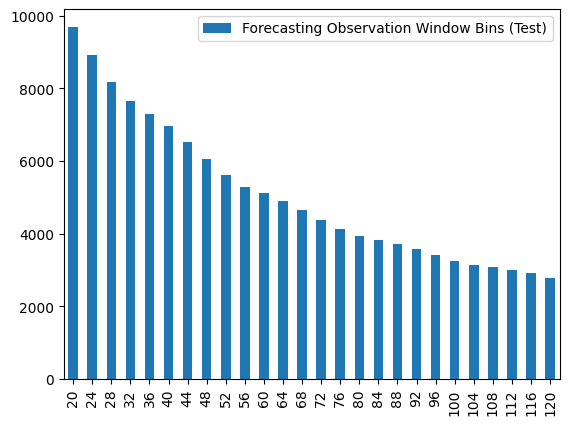

In [19]:
from collections import Counter
# visualization 
df = pd.DataFrame.from_dict(Counter(hours), orient='index', columns=['Forecasting Observation Window Bins (Test)'])
df.plot.bar()

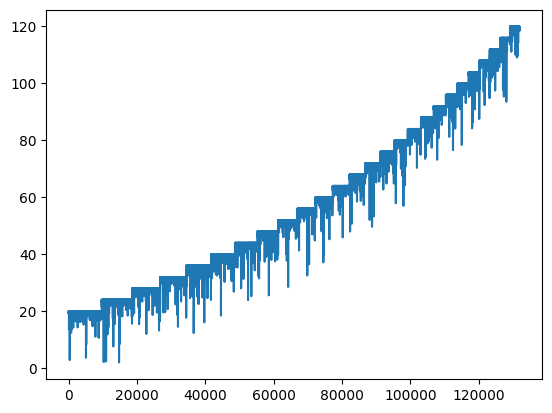

In [20]:
import matplotlib.pyplot as plt

plt.plot(range(len(max_hours)), max_hours)
plt.show()

## Eva

In [21]:
# data_path = 'Exp1/forecasting_preds_test_1.pkl'
# data, var_to_ind = pickle.load(open(data_path, 'rb'))
# data

In [18]:
import tensorflow.keras.backend as K
def forecast_loss(y_true, y_pred):
    V=134
    return K.sum(y_true[:,V:]*(y_true[:,:V]-y_pred)**2, axis=-1)

In [19]:
y_true = []
for y in test_data['forecasting_test_op']:
  y_true.append(y)
y_true = np.array(y_true)
# y_true

In [20]:
y_pred = []
for y in test_data['forecasting_pred']:
  y_pred.append(y)
y_pred = np.array(y_pred)
# y_pred

In [21]:
mmse = forecast_loss(y_true, y_pred)
s = 0
for i in mmse:
  s += i
s/len(mmse)

<tf.Tensor: shape=(), dtype=float64, numpy=5.201525200524849>

In [26]:
mmse = forecast_loss(y_true, y_pred)
s = 0
for i in mmse:
  s += i
s/len(mmse)

<tf.Tensor: shape=(), dtype=float64, numpy=5.250917064919449>